[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/diogoflim/PO_II/blob/main/3_Otimização_Redes/FluxoMax_CorteMin/MaxFlowMinCut.ipynb)

In [155]:
import networkx as nx
import matplotlib.pyplot as plt


In [156]:
# Cria um objeto de grafo direcionado
G = nx.DiGraph()

# Adiciona nós ao grafo
G.add_node('s')  # Nó fonte
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_node('t')  # Nó destino

# Adiciona arestas ao grafo com suas capacidades
G.add_edge('s', 'a', capacidade=3)
G.add_edge('s', 'b', capacidade=2)
G.add_edge('a', 'b', capacidade=1)
G.add_edge('a', 'c', capacidade=3)
G.add_edge('b', 'd', capacidade=2)
G.add_edge('c', 'd', capacidade=2)
G.add_edge('c', 't', capacidade=3)
G.add_edge('d', 't', capacidade=3)


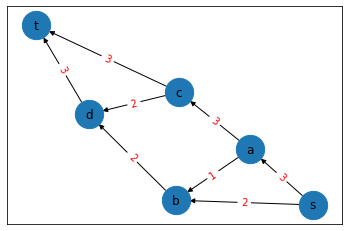

In [157]:
# Desenha o grafo com os rótulos de capacidade nas arestas

pos =  nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels=True, node_size = 800)
aresta_rotulos = {(u, v): d['capacidade'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=aresta_rotulos, font_color='red')
plt.show()


### Fluxo Máximo

In [158]:
# Calcula o fluxo máximo
fluxo_max, fluxo_dict = nx.maximum_flow(G, 's', 't', capacity = 'capacidade')


In [159]:
# Imprime os resultados
print("Fluxo máximo:", fluxo_max)
print("Dicionário de fluxo:", fluxo_dict)


Fluxo máximo: 5
Dicionário de fluxo: {'s': {'a': 3, 'b': 2}, 'a': {'b': 0, 'c': 3}, 'b': {'d': 2}, 'c': {'d': 0, 't': 3}, 'd': {'t': 2}, 't': {}}


### Corte Mínimo

In [160]:
# Corte mínimo
corte_min, part = nx.minimum_cut(G, 's', 't', capacity = 'capacidade')

In [161]:
# Imprime os resultados
print("Valor do Corte Mínimo:", corte_min)
print("Partição dos vértices a partir do corte mínimo:", part)


Valor do Corte Mínimo: 5
Partição dos vértices a partir do corte mínimo: ({'b', 'a', 's'}, {'c', 'd', 't'})


## Modelando um Problema do Fluxo Máximo como Problema do Fluxo de Custo Mínimo

In [162]:
V = list(G.nodes())
E = list(G.edges())

E.append(('s','t'))


print(V)
print(E)

['s', 'a', 'b', 'c', 'd', 't']
[('s', 'a'), ('s', 'b'), ('a', 'b'), ('a', 'c'), ('b', 'd'), ('c', 'd'), ('c', 't'), ('d', 't'), ('s', 't')]


In [163]:
u = nx.get_edge_attributes(G, 'capacidade')
u[('s','t')] = 10000
u


{('s', 'a'): 3,
 ('s', 'b'): 2,
 ('a', 'b'): 1,
 ('a', 'c'): 3,
 ('b', 'd'): 2,
 ('c', 'd'): 2,
 ('c', 't'): 3,
 ('d', 't'): 3,
 ('s', 't'): 10000}

In [164]:
c = {}
for e in E: c[e] = 0
c[('s','t')] = 100
c

{('s', 'a'): 0,
 ('s', 'b'): 0,
 ('a', 'b'): 0,
 ('a', 'c'): 0,
 ('b', 'd'): 0,
 ('c', 'd'): 0,
 ('c', 't'): 0,
 ('d', 't'): 0,
 ('s', 't'): 100}

In [165]:
F = 8

fluxos = {'s': F,
          'a':0,
          'b':0,
          'c':0,
          'd':0,
           't': -F}

fluxos

{'s': 8, 'a': 0, 'b': 0, 'c': 0, 'd': 0, 't': -8}

In [166]:
import pyomo.environ as pe

In [167]:
# Criando uma instância do modelo
M = pe.ConcreteModel() 

# Grafo
M.V = pe.Set(initialize = V) 
M.E = pe.Set(initialize = E)

#Parâmetros
M.c = pe.Param(M.E, initialize = c) #custos
M.u = pe.Param(M.E, initialize = u) #limites superiores
M.b = pe.Param(M.V, initialize = fluxos) #fluxos


In [168]:
# VARIÁVEIS DE DECISÃO
M.x = pe.Var(M.E, within= pe.NonNegativeReals)


In [169]:
def custo_total (M):
    return sum(M.x[e] * M.c[e] for e in M.E)

# FUNÇÃO OBJETIVO
M.z = pe.Objective(rule = custo_total, sense= pe.minimize)
  

In [170]:
M.R_fluxos = pe.Constraint(M.V, rule= lambda M, i: sum(M.x[(i, j)] for j in M.V if (i,j) in M.E) - sum(M.x[(j, i)] for j in M.V if (j,i) in M.E) == M.b[i])


M.R_limites =pe.ConstraintList()
for e in M.E:
    M.R_limites.add(expr =  M.x[e] <= M.u[e])


In [171]:
# RESOLUÇÃO DO MODELO
pe.SolverFactory('glpk').solve(M)

{'Problem': [{'Name': 'unknown', 'Lower bound': 300.0, 'Upper bound': 300.0, 'Number of objectives': 1, 'Number of constraints': 16, 'Number of variables': 10, 'Number of nonzeros': 28, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.048947811126708984}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [172]:
print(f"z= {pe.value(M.z)}\n----------------\n")
for k in M.x.keys(): 
    if pe.value(M.x[k]) > 0: 
        print (f"x_{k} = {pe.value(M.x[k])}")

z= 300.0
----------------

x_('s', 'a') = 3.0
x_('s', 'b') = 2.0
x_('a', 'c') = 3.0
x_('b', 'd') = 2.0
x_('c', 't') = 3.0
x_('d', 't') = 2.0
x_('s', 't') = 3.0


Perceba que foram enviadas 3 unidades via arco fantasma ('s', 't'). Por isso o custo foi de 300! 

Para encontrar a resposta do fluxo máximo, basta somar o que saiu do vértice 's' ou somar o que entrou em 't',  **sem contar o arco ('s', 't')**.

In [180]:
resposta_1 = sum(pe.value(M.x[k]) for k in M.x.keys() if k[0] == 's' and k[1]!='t')
# ou
resposta_2 = sum(pe.value(M.x[k]) for k in M.x.keys() if k[0] != 's' and k[1]=='t')
# ou
resposta_3 = sum(pe.value(M.x[k]) for k in M.x.keys() if k!= ('s','t') and k[0] == 's')
# ou
resposta_4 = sum(pe.value(M.x[k]) for k in M.x.keys() if k!= ('s','t') and k[1] == 't')

print(resposta_1)
print(resposta_2)
print(resposta_3)
print(resposta_4)

5.0
5.0
5.0
5.0
